In [3]:
import numpy as np, matplotlib.pyplot as plt, healpy as hp
from radiono import rm, utils as ut
%matplotlib inline 

In [7]:
# BLURB

# radionopy is a natural next step from existing codes that calculate the RM for a given pointing on the sky for
# radio telescopes. Instead of a single pointing being printed to file, it holds all data in python arrays, which
# themselves are called from an IonoMap object.

# The code's heritage is mainly from ionFR (http://sourceforge.net/projects/ionfr), which unfortunately includes bugs
# (e.g. RMs are always positive) and requires some inelegant string arguments. While radionopy is under active 
# development (most [all?] bugs found & removed), some of this heritage in terms of function arguments has not yet
# been superseded.

# In this tutorial, I will give a flavour of different use cases for radionopy by manipulating the IonoMap object. It
# assumes one has executed `python setup.py develop` in the repo, which will compile the geomagnetic field model.

In [6]:
# Choose what day you want to get data for.
YYYY,MM,DD = '2012','01','01' 

# State your latitude and longitude, since the B-field projection depends on your location. Note the funny way of
# stating negative values -- the final character for this Southern-hemisphere site (the PAPER/HERA site, actually)
# is denoted with an "s" for south. Use "n" for north. Same for "e" and "w" for longitude. No minus-signs used. This
# will be simplified in later releases.

obsLat,obsLon = '30d43m17.5ss','21d25m41.9se'

# Under the hood, rm.IonoMap is doing an anonymous ftp to the IONEX server to obtain TEC data for that night. For an
# overview of IONEX files, see ionex_memo.pdf in radionopy/docs. Unless specified in an argument to the below call,
# the IONEX file will be placed in a directory named "TEC". If the file already exists, no ftp-pull will occur.
IM = rm.IonoMap(obsLat,obsLon,['%s-%s-%s'%(YYYY,MM,DD)])

(24, 3072)


TypeError: not all arguments converted during string formatting

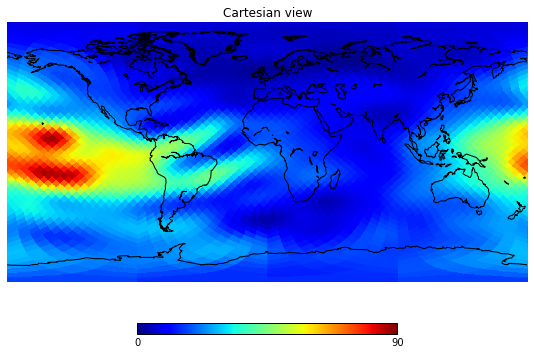

In [11]:
from mpl_toolkits.basemap import Basemap

# TEC and rms(TEC) are contained in the raw IONEX file as a spherical harmonic decomposition,
# making it a natural step to display as a full-sky map. ionh is the height of the ionosphere.
tec,rmstec,ionh = IM.ionex_data(YYYY,MM,DD)

print tec.shape # UT hours, npix
tecu = 0.1*tec # convert to TECU

mc = Basemap(projection='cyl', resolution='c')
tecuUT=hp.cartview(tecu[0,:],flip='geo',max=90,min=0,return_projected_map=True) # get map for UT=0 hr
mc.drawcoastlines()
_tecu = mc.imshow(tecuUT, alpha=0.6,vmax=90,vmin=0)
mc.colorbar(location='bottom')
plt.show()

/Users/saulkohn/github/radionopy/radiono/rm.py:167: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  TEC_path, RMS_TEC_path = itp.get_los_tec(tec_hp[UT], rms_hp[UT],


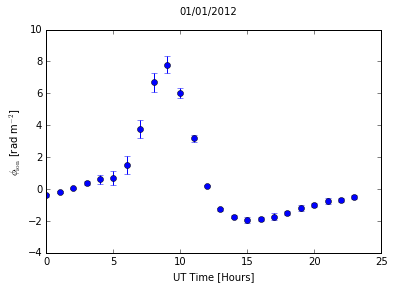

In [12]:
# radionopy uses the International Geomagnetic Reference Field v11 (IGRF; Finlay et al. 2010), projecting it onto the
# IONEX TEC values and integrating, to calculate an RM for every ra,dec asked for. This can be a single (RA,Dec),
# the whole sphere, or anything inbetween. I'll show an example of each end:

## SINGLE POINTING (Fornax A from PAPER/HERA site)

ra,dec = np.radians([50.67,-37.21]) #approx position of Fornax A (OK for an example method...). Note radians.
IM.get_radec_RM([ra],[dec])

#the IonoMap object will now contain arrays IM.RM, IM.dRM, and more. They are len(ra) x UT hours shapes.
plt.errorbar(range(24), IM.RMs[0,:], yerr=IM.dRMs[0,:], fmt='bo', ecolor='b')
plt.xlabel(r'UT Time [Hours]')
plt.ylabel(r'$\phi_{\rm ion}$ [rad m$^{-2}$]')
plt.suptitle(r'%s'%('/'.join([DD,MM,YYYY])))
plt.show()

//anaconda/envs/py27/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


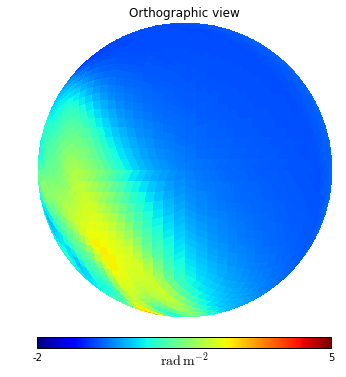

In [14]:
## HEALPix GRID (all-sky RM from the PAPER/HERA site)
ras,decs = ut.nsideToDeclRa(16) # simple generator function for ra, dec coords on a HealPix sphere

# NOTE: if we called this in the same cell as above before plotting, things would go wrong, since it will overwrite
# the arrays with new ones based on the argument supplied.
IM.get_radec_RM(ras,decs)

# get map as viewed from site (half-sky). Rotation [0,90] is just a choice of convention for what direction "zenith" 
# is in.
hp.orthview(IM.RMs[0,0,:],half_sky=True,rot=[0,90],max=5,min=-2,unit=r'${\rm rad\,m^{-2}}$')
plt.show()